# Von Mises Elastoplasticity

This example gives the numerical implementation of the Von Mises elastoplasticity model (Houlsby & Puzrin, 2006).

The Helmholtz free energy $f$ and the yield function $y$ for this model are given by:

\begin{align*}
f = & \frac{K}{2} \epsilon_{ii} \epsilon_{jj} + G (\epsilon'_{ij}-\alpha'_{ij}) (\epsilon'_{ij}-\alpha'_{ij})\\
y = & \sqrt{\chi'_{ij} \chi'_{ij}} - k \sqrt{2} = 0
\end{align*}

For reference, the deviatoric part of a second order tensor is:
\begin{equation*}
a'_{ij} = a_{ij} - \frac{1}{3} \delta_{ij} a_{kk}
\end{equation*}

Differentiation of the energy potential gives:
\begin{align*}
\sigma_{ij} = & \frac{\partial f}{\partial \epsilon_{ij}} = K \epsilon_{kk} \delta_{ij} + 2 G (\epsilon'_{ij} - \alpha'_{ij}) \\
\bar{\chi}_{ij} = & - \frac{\partial f}{\partial \alpha_{ij}} = 2 G (\epsilon'_{ij} - \alpha'_{ij})
\end{align*}

Double differentiation gives:
\begin{align*}
\frac{\partial^2 f}{\partial \epsilon_{ij} \partial \epsilon_{kl}} = &
\left(K - \frac{2G}{3} \right) \delta_{ij} \delta_{kl} + 2 G \delta_{ik} \delta_{jl} \\
\frac{\partial^2 f}{\partial \epsilon_{ij} \partial \alpha_{kl}} = & \; 2G \left(
\frac{1}{3} \delta_{ij} \delta_{kl} - \delta_{ik} \delta_{jl} \right) \\
\frac{\partial^2 f}{\partial \alpha_{ij} \partial \epsilon_{kl}} = & \; 2G \left(
\frac{1}{3} \delta_{ij} \delta_{kl} - \delta_{ik} \delta_{jl} \right) \\
\frac{\partial^2 f}{\partial \alpha_{ij} \partial \alpha_{kl}} = & -2G \left(
\frac{1}{3} \delta_{ij} \delta_{kl} - \delta_{ik} \delta_{jl} \right) \\
\end{align*}

Differentiation of the yield function gives:
\begin{equation*}
\frac{\partial y}{\partial \chi_{ij}} = 2 \lambda S_{ij}(\chi'_{ij})
\end{equation*}

The incremental response follows from a standardised approach, which can be written in the following form:

\begin{equation*}
\begin{Bmatrix}
\dot{\sigma}_{ij} \\
-\dot{\bar{\chi}}_{ij}
\end{Bmatrix}= 
\begin{bmatrix}
\frac{\partial^2 f}{\partial \epsilon_{ij} \partial \epsilon_{kl}} & \frac{\partial^2 f}{\partial \epsilon_{ij} \partial \alpha_{kl}} \\
\frac{\partial^2 f}{\partial \epsilon_{ij} \partial \alpha_{kl}} & \frac{\partial^2 f}{\partial \alpha_{ij} \partial \alpha_{kl}} \\
\end{bmatrix} 
\begin{Bmatrix}
\dot{\epsilon}_{kl} \\
\dot{\alpha}_{kl}
\end{Bmatrix}
\end{equation*}

The rate of hardening strain is defined by:

\begin{equation*}
\dot{\alpha}_{ij} = \lambda \frac{\partial y}{\partial \chi_{ij}}
\end{equation*}

where the multiplyer $\lambda$ is derived from the consistency condition:
\begin{equation*}
\dot{y} = 0 = \frac{\partial y}{\partial \sigma_{ij}} \dot{\sigma} _{ij}+ \frac{\partial y}{\partial \chi_{ij}} \dot{\chi}_{ij} + \frac{\partial y}{\partial \alpha_{ij}} \dot{\alpha}_{ij}
\end{equation*}

Combining the above equations for the one dimensional model with Ziegler's orthogonality condition ($\chi=\bar{\chi}$) gives:
\begin{align*}
0 = & \frac{\partial y}{\partial \chi_{ij}} \left( \frac{\partial^2 f}{\partial \epsilon_{ij} \partial \alpha_{kl}} \dot{\epsilon}_{kl} + \frac{\partial^2 f}{\partial \alpha_{ij} \partial \alpha_{kl}} \lambda \frac{\partial y}{\partial \chi_{kl}} \right) \\
\lambda = & - \frac{\frac{\partial y}{\partial \chi_{ij}} \frac{\partial^2 f}{\partial \epsilon_{ij} \partial \alpha_{kl}} }{\frac{\partial y}{\partial \chi_{ij}} \frac{\partial^2 f}{\partial \alpha_{ij} \partial \alpha_{kl}} \frac{\partial y}{\partial \chi_{kl}}} \dot{\epsilon}_{kl}
\end{align*}

In [1]:
# The implementation of the above equations is given below
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Model parameters
K = 1
G = 1
k = 1

# Initialise the model state parameters
sigma = np.zeros((9,1))
chi = np.zeros((9,1))
alpha = np.zeros((9,1))
epsilon_0 = np.zeros((9,1))

# Define the applied strain history
epsilon_max = 1
theta_max = 2 * np.pi
d_theta_abs = 0.001
theta = np.arange(0, theta_max, d_theta_abs)

epsilon_xx_history = epsilon_max * np.sin(theta)

delta_ij = np.transpose(np.array([[1, 0, 0, 0, 1, 0, 0, 0, 1]]))
delta_kl = np.transpose(delta_ij)
delta_ik = np.transpose(np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1]]))
delta_jl = np.transpose(delta_ik)

d2_f_d_e2 =  (K - 2 * G / 3) * np.matmul(delta_ij, delta_kl) + 2 * G * np.matmul(delta_ik, delta_jl)
d2_f_d_a2 =-2 * G * (np.matmul(delta_ij, delta_kl) / 3 - np.matmul(delta_ik, delta_jl))
d2_f_d_ea = 2 * G * (np.matmul(delta_ij, delta_kl) / 3 - np.matmul(delta_ik, delta_jl))
d2_f_d_ae = 2 * G * (np.matmul(delta_ij, delta_kl) / 3 - np.matmul(delta_ik, delta_jl))

sigma_history = []
epsilon_history = []

# Calculate the incremental response
for epsilon_xx in epsilon_xx_history:
        
    epsilon = np.transpose(np.array([[epsilon_xx, 0, 0, 0, 0, 0, 0, 0, 0]]))
    d_epsilon = epsilon-epsilon_0
    
    d_epsilon_dev = d_epsilon - 1/3 * delta_ij * np.matmul(np.transpose(delta_ij), d_epsilon)
    chi_dev = chi - 1/3 * delta_ij * np.matmul(np.transpose(delta_ij), chi)
    norm_chi_dev = np.sqrt(np.matmul(np.transpose(chi_dev), chi_dev))
    y = norm_chi_dev - k * np.sqrt(2)
    
    if norm_chi_dev == 0:
        d_y_d_chi = np.zeros((9,1))
    else:
        d_y_d_chi = 2 * chi_dev / norm_chi_dev
            
    if y > 0:
        # Perform trial elastic step
        d_chi_trial = - np.matmul(d2_f_d_ae, d_epsilon)
        chi_trial = chi + d_chi_trial
        chi_dev_trial = chi_trial - 1/3 * delta_ij * np.matmul(np.transpose(delta_ij), chi_trial)
        norm_chi_dev_trial = np.sqrt(np.matmul(np.transpose(chi_dev_trial), chi_dev_trial))
        y_trial = norm_chi_dev_trial - k * np.sqrt(2)
                        
        if y_trial > y:
            lambda_ = - np.matmul(np.matmul(np.transpose(d_y_d_chi), d2_f_d_ea)/np.matmul(np.transpose(d_y_d_chi), np.matmul(d2_f_d_a2, d_y_d_chi)), d_epsilon)
        else:
            lambda_ = 0
    else:
        lambda_ = 0
                
    d_alpha = lambda_ * d_y_d_chi
        
    d_sigma = np.matmul(d2_f_d_e2, d_epsilon) + np.matmul(d2_f_d_ea, d_alpha)
    d_chi = -(np.matmul(d2_f_d_ae, d_epsilon) + np.matmul(d2_f_d_a2, d_alpha))
    
    sigma = sigma + d_sigma
    chi = chi + d_chi
    alpha = alpha + d_alpha
    epsilon_0 = epsilon
    
    sigma_history.append(sigma)
    epsilon_history.append(epsilon)
    
epsilon_history_array = np.hstack(epsilon_history)
sigma_history_array = np.hstack(sigma_history)

In [2]:
def stress_invariants(sigma_history_array):
        
    n_columns = np.size(sigma_history_array,1)
    
    I_history = np.zeros((n_columns, 3))
    J_history = np.zeros((n_columns, 3))
        
    for i in range (0, n_columns):
        
        sigma = sigma_history_array[:, i]
        
        sigma_mat = np.array([[sigma[0], sigma[1], sigma[2]],
                              [sigma[3], sigma[4], sigma[5]],
                              [sigma[6], sigma[7], sigma[8]]])
                
        I_1 = np.trace(sigma_mat)  
        I_2 = 1 / 2 * np.linalg.norm(sigma_mat)**2  
        I_3 = np.linalg.det(sigma_mat)
        
        s_mat = np.array([[sigma[0]-I_1/3, sigma[1], sigma[2]],
                          [sigma[3], sigma[4]-I_1/3, sigma[5]],
                          [sigma[6], sigma[7], sigma[8]-I_1/3]])
        
        J_1 = np.trace(s_mat)
        J_2 = 1 / 2 * np.linalg.norm(s_mat)**2          
        J_3 = np.linalg.det(s_mat)
                
        I_history[i,:] = np.array([I_1, I_2, I_3])
        J_history[i,:] = np.array([J_1, J_2, J_3])
                
    return I_history, J_history

In [3]:
# Calculate the stress invariants from the output
I_history, J_history = stress_invariants(sigma_history_array)

Text(0,0.5,'$\\sigma_{xx}$')

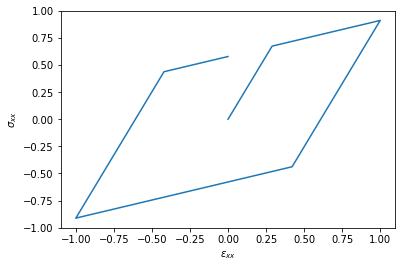

In [4]:
# Show the stress-strain response in the xx direction
plt.figure(1)
plt.plot(epsilon_history_array[0,:], sigma_history_array[0,:])
plt.xlabel('$\epsilon_{xx}$')
plt.ylabel('$\sigma_{xx}$')

Text(0,0.5,'$J_2$')

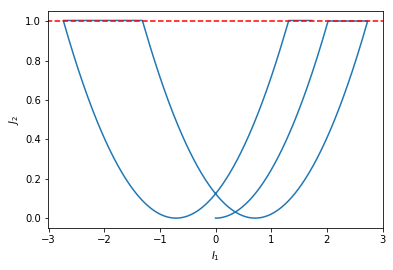

In [5]:
# This first and second stress invariant, where the Von Mises criterion is J_2 = sqrt(k)
plt.figure(3)
plt.plot(I_history[:, 0], J_history[:, 1])
plt.axhline(y=np.sqrt(k), xmin=-1, xmax=1, color='r', linestyle='--')
plt.xlabel('$I_1$')
plt.ylabel('$J_2$')